# Mushroom classification - Part II: Neural network with Keras 

Time to design a neural network

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

2022-06-01 12:40:12.383206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 12:40:12.383221: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout
from keras.utils.vis_utils import plot_model

In [4]:
with open('Data/train.npy', 'rb') as f:
    train_df = np.load(f)
    train_class = np.load(f)

In [5]:
with open('Data/test.npy', 'rb') as f:
    test_df = np.load(f)
    test_class = np.load(f)

In [6]:
train_df

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
def create_model(depth, size=1):
    model = Sequential()
    
    model.add(Input((train_df.shape[1], )))
    
    for d in range(depth):
        model.add(Dense(16 * size, activation="relu"))
        model.add(Dense(32 * size, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="mean_squared_error", metrics = ["accuracy"])
    
    return model

model_1 = create_model(1)
model_1_2 = create_model(1,2)
model_10 = create_model(20)
model_10_2 = create_model(20,2)

2022-06-01 12:40:13.471177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 12:40:13.471789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 12:40:13.471961: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-01 12:40:13.472116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-01 12:40:13.472270: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [8]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                1808      
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,385
Trainable params: 2,385
Non-trainable params: 0
_________________________________________________________________


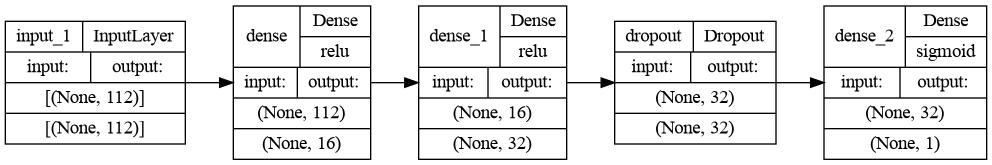

In [9]:
plot_model(model_1, show_shapes=True, to_file="Figures/model_1.png", rankdir = "LR", show_layer_activations=True)

### Manual training saving the gradients per layer

In [10]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()
 
def train_model(X, y, model, n_epochs, batch_size):
    "Run training loop manually"
    train_dataset = tf.data.Dataset.from_tensor_slices((X, y))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
 
    gradhistory = []
    losshistory = []
    
    def recordweight():
        data = {}
        for g,w in zip(grads, model.trainable_weights):
            if '/kernel:' not in w.name:
                continue # skip bias
            name = w.name.split("/")[0]
            data[name] = g.numpy()
        gradhistory.append(data)
        losshistory.append(loss_value.numpy())
        
    for epoch in range(n_epochs):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                y_pred = model(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, y_pred)
 
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
 
            if step == 0:
                recordweight()
    # After all epochs, record again
    recordweight()
    
    return gradhistory, losshistory

In [11]:
epochs = 10

In [12]:
def plot_gradient(model, gradhistory, losshistory):
    "Plot gradient mean across epochs"
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    ax.set_title("Mean gradient", fontsize = 15)
    for key in gradhistory[0]:
        ax.plot(range(len(gradhistory)), [w[key].mean() for w in gradhistory], label=key)
    ax.set_xlabel('Epochs')
    ax.set_xlabel('Gradient')
    ax.legend()
    
    plt.savefig(f'Figures/gradients_{model}.png', facecolor='white', transparent=False)

### Modelo 1

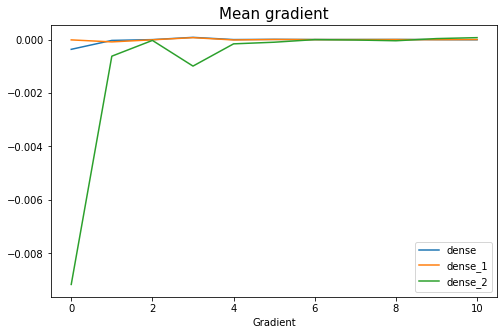

In [13]:
gradhist, losshist = train_model(train_df, train_class, model_1, n_epochs = epochs, batch_size = 32)
plot_gradient("model1", gradhist, losshist)

### Model 1 double size

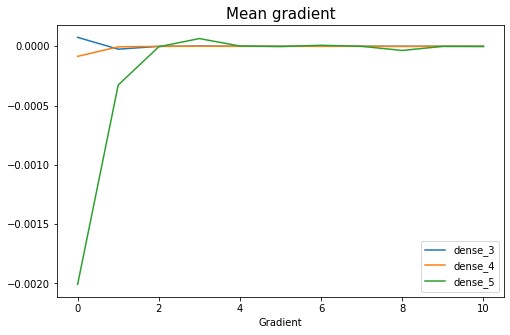

In [14]:
gradhist, losshist = train_model(train_df, train_class, model_1_2, n_epochs = epochs, batch_size = 32)
plot_gradient("model1_2", gradhist, losshist)

### Model 2

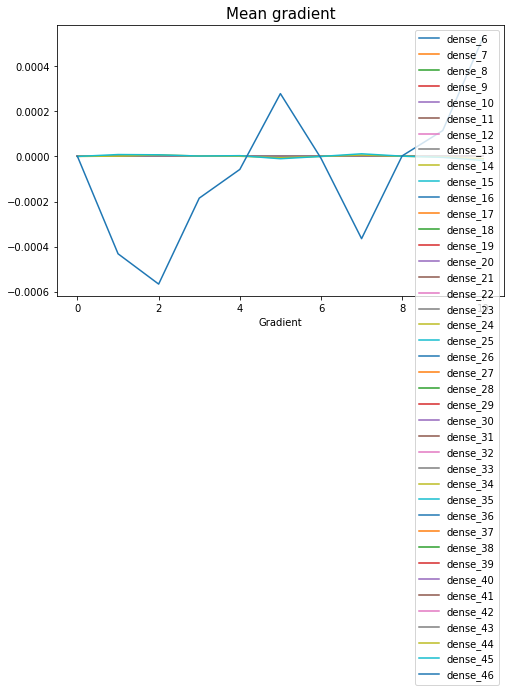

In [15]:
gradhist, losshist = train_model(train_df, train_class, model_10, n_epochs = epochs, batch_size = 32)
plot_gradient("model2", gradhist, losshist)

### Model 2 double size

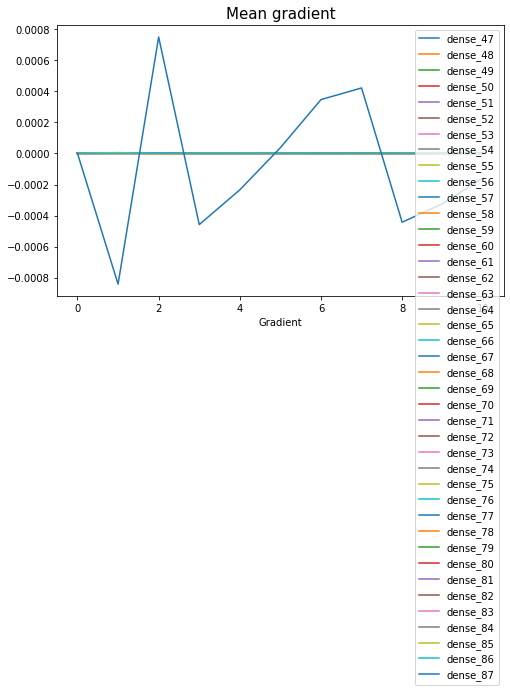

In [16]:
gradhist, losshist = train_model(train_df, train_class, model_10_2, n_epochs = epochs, batch_size = 32)
plot_gradient("model2_2", gradhist, losshist)